# Uvoz i vizualizacija ulaznog podatkovnog skupa

## Uvoz podatkovnog skupa

In [66]:
import kagglehub

# Skidanje zadnje verzije dataseta
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [5]:
import os
import glob
for dirpath,dirnames,filenames in os.walk(dataset_path):
    print(f'Nalazi se {len(dirnames)} direktorija i {len(filenames)} slika u direktoriju na putanji {dirpath}.')

Nalazi se 2 direktorija i 0 slika u direktoriju na putanji /kaggle/input/brain-tumor-mri-dataset.
Nalazi se 4 direktorija i 0 slika u direktoriju na putanji /kaggle/input/brain-tumor-mri-dataset/Training.
Nalazi se 0 direktorija i 1457 slika u direktoriju na putanji /kaggle/input/brain-tumor-mri-dataset/Training/pituitary.
Nalazi se 0 direktorija i 1595 slika u direktoriju na putanji /kaggle/input/brain-tumor-mri-dataset/Training/notumor.
Nalazi se 0 direktorija i 1339 slika u direktoriju na putanji /kaggle/input/brain-tumor-mri-dataset/Training/meningioma.
Nalazi se 0 direktorija i 1321 slika u direktoriju na putanji /kaggle/input/brain-tumor-mri-dataset/Training/glioma.
Nalazi se 4 direktorija i 0 slika u direktoriju na putanji /kaggle/input/brain-tumor-mri-dataset/Testing.
Nalazi se 0 direktorija i 300 slika u direktoriju na putanji /kaggle/input/brain-tumor-mri-dataset/Testing/pituitary.
Nalazi se 0 direktorija i 405 slika u direktoriju na putanji /kaggle/input/brain-tumor-mri-data

In [6]:
train_dir = os.path.join(dataset_path,'Training')
test_dir = os.path.join(dataset_path, 'Testing')
train_images = glob.glob(os.path.join(train_dir,'**','*.jpg'))
test_images = glob.glob(os.path.join(test_dir,'**','*.jpg'))
total_images = train_images + test_images
print(f'Ukupno je {len(total_images)} slika u podatkovnom skupu i skup za treniranje i testiranje je podijeljen u omjeru {len(train_images)/ len(total_images)* 100 :.2f}:{len(test_images)/ len(total_images)* 100 :.2f}')
num_classes = len(glob.glob(os.path.join(train_dir,'*')))
print(f'Ukupno je {num_classes} različitih klasa.')

Ukupno je 7023 slika u podatkovnom skupu i skup za treniranje i testiranje je podijeljen u omjeru 81.33:18.67
Ukupno je 4 različitih klasa.


Prema ispisima u prošlim ćelijama možemo zaključiti da su sve klase približno jednako zastupljene te da je podatkovni skup podijeljen u standardnom omjeru.

 ## Vizualizacija dataseta

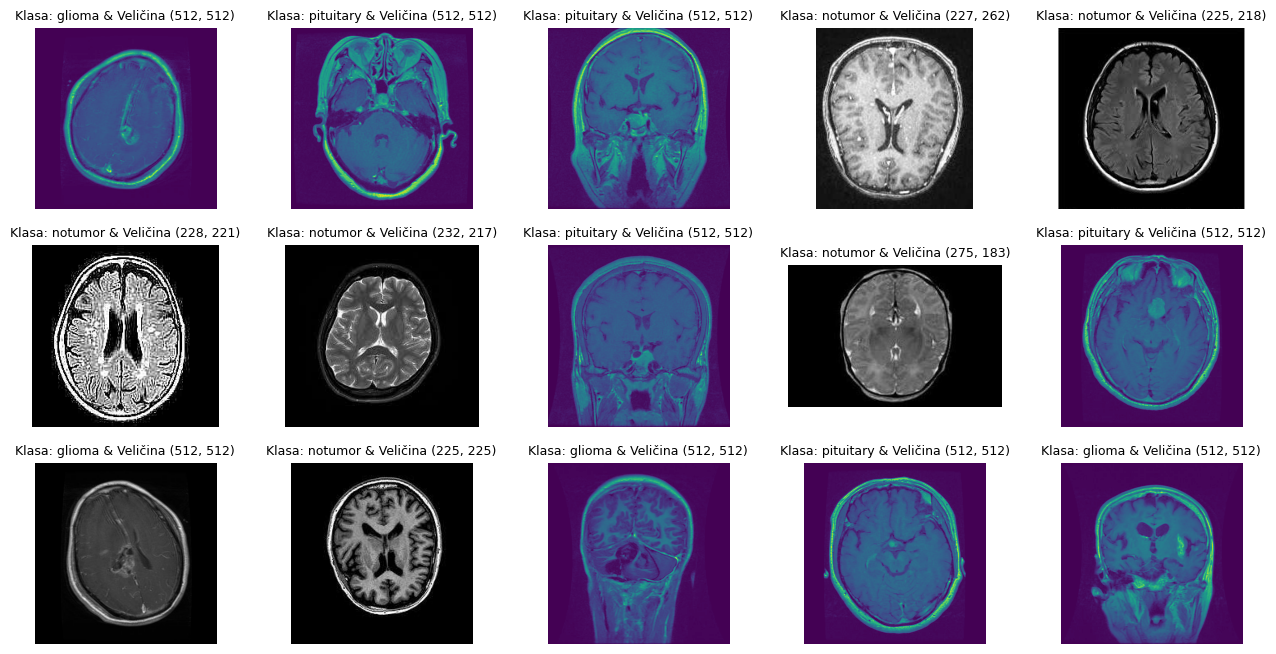

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

random.seed(42)
random_images_paths = random.sample(total_images, 15)
_,axs = plt.subplots(3,5, figsize = (16,8))
for i, image_path in enumerate(random_images_paths):
    with Image.open(image_path) as img:
        img_class = image_path.split('/')[-2]
        axs[i//5, i%5].imshow(img)
        axs[i//5, i%5].axis('off')
        axs[i//5, i%5].set_title(f'Klasa: {img_class} & Veličina {img.size}', fontsize = 9)


# Skidanje prethodno treniranih modela

U ovome projektu koristit ćemo modele s već treniranim težinama i zamrznut ćemo sve ili većinu parametara koji služe izdvajanju značajki na slikama dok će se ostali parametri koji pripadaju klasifikacijskom sloju/slojevima moći trenirati.

Razlog zašto to radimo je taj da su težine prethodno treniranih modela dobivene treniranjem te arhitekture modela na većem podatkovnom skupu (ImageNet - 14 milijuna slika) te su zbog toga ti modeli dobri u izdvajanju značajki sa slika dok klasifikacijski sloj trebamo prilagoditi broju klasa našeg podatkovnog skupa

In [8]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
! pip install torchinfo
import torchinfo
from torchinfo import summary

# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Efficientnet_v2_s arhitektura

Prvo ćemo isprobati model s Efficientnet_v2 s arhitekturom.

Nakon što skinemo model s torchvision baze modela pridodajemo mu atribute name i weights (u idućim funkcijama nećemo trebati slati te atribute kao parametre već ćemo poslati samo model te će funkcija sama uzeti atribute koje treba).

In [9]:
# Skidanje modela
model_1 = torchvision.models.efficientnet_v2_s(weights='DEFAULT').to(device)
model_1.name = 'efficientnet_v2_s'
model_1.weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
# Ispis transformacija slika na kojima je bio treniran model
model_1.weights.transforms()


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 220MB/s]


ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
# ispis sažetka modela s ciljem da se uoči koje slojeve modela trebamo zamrznuti
summary(model=model_1,
        input_size=(32, 3, 384, 384),
        col_names=["input_size", "output_size", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 1000]           True
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   True
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   True
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   True
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   True
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 24, 192, 192]   True
│    │    └─FusedMBConv (0)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   True
│    │    └─FusedMBConv (

In [11]:
# zamrzavanje slojeva koji imaju ulogu ekstrakcije značajki i promjena broja izlaza zadnjeg sloja
for layer in list(model_1.features.children())[:-1]:
    for param in layer.parameters():
        param.requires_grad = False

model_1.classifier[1] = nn.Linear(in_features = 1280, out_features = num_classes)

## Resnet101 arhitektura

Slični postupak radimo i za drugi i treći model.

In [12]:
model_2 = torchvision.models.resnet101(weights='DEFAULT').to(device)
model_2.name = 'resnet101'
model_2.weights = torchvision.models.ResNet101_Weights.DEFAULT
model_2.weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 214MB/s] 


ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [13]:
summary(model=model_2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     True
│    │    └─BatchNorm2d (bn1)            [32, 64, 56, 56]     [32, 64, 56, 56]     True
│    │    └─ReLU (relu)                  [32, 64, 56, 56]     [32, 64, 56, 56]     --
│    │    └─Conv2d (conv2)       

In [14]:
for name, param in model_2.named_parameters():
    if 'layer4' not in name and  'fc' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

model_2.fc= nn.Linear(in_features = 2048, out_features = num_classes)

## VGG19 arhitektura

In [87]:
model_3 = torchvision.models.vgg19(weights='DEFAULT').to(device)
model_3.name = 'vgg19'
model_3.weights = torchvision.models.VGG19_Weights.DEFAULT
model_3.weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [88]:
summary(model=model_3,
        input_size=(32, 3, 256, 256),
        col_names=["input_size", "output_size", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Trainable
VGG (VGG)                                [32, 3, 256, 256]    [32, 1000]           True
├─Sequential (features)                  [32, 3, 256, 256]    [32, 512, 8, 8]      True
│    └─Conv2d (0)                        [32, 3, 256, 256]    [32, 64, 256, 256]   True
│    └─ReLU (1)                          [32, 64, 256, 256]   [32, 64, 256, 256]   --
│    └─Conv2d (2)                        [32, 64, 256, 256]   [32, 64, 256, 256]   True
│    └─ReLU (3)                          [32, 64, 256, 256]   [32, 64, 256, 256]   --
│    └─MaxPool2d (4)                     [32, 64, 256, 256]   [32, 64, 128, 128]   --
│    └─Conv2d (5)                        [32, 64, 128, 128]   [32, 128, 128, 128]  True
│    └─ReLU (6)                          [32, 128, 128, 128]  [32, 128, 128, 128]  --
│    └─Conv2d (7)                        [32, 128, 128, 128]  [32, 128, 128, 128]  True
│    └─ReLU (8)                    

In [89]:
for param in model_3.features.parameters():
    param.requires_grad = False
model_3.classifier[-1] = nn.Linear(in_features = 4096, out_features = num_classes)

# Izrada skupova podataka i učitavača podataka

In [18]:
def create_dataloaders(train_dir: str, test_dir: str, transform: transforms.Compose, batch_size : int , num_workers :int = os.cpu_count()):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_dataloader, test_dataloader

In [19]:
train_dataloader_1, test_dataloader_1 = create_dataloaders(train_dir, test_dir,model_1.weights.transforms(),32)
train_dataloader_2, test_dataloader_2 = create_dataloaders(train_dir, test_dir,model_2.weights.transforms(),32)
train_dataloader_3, test_dataloader_3 = create_dataloaders(train_dir, test_dir,model_3.weights.transforms(),32)

# Treniranje modela

Prvo je potrebno odabrati funkciju gubitka i optimizator.
Jedna od funkcija gubitka koja se najviše koristi za klasifikacijske zadatke je **CrossEntropyLoss** te ona uspoređuje predikcije modela (logiti) s točnim klasama i računa koliko je model bio daleko od točnih odgovora.


\begin{cases}
\frac{ \sum_{n=1}^{N} w_{y_n} \cdot \mathbf{1}\{y_n \ne \text{ignore\_index}\} \cdot \ell_n }{ \sum_{n=1}^{N} w_{y_n} \cdot \mathbf{1}\{y_n \ne \text{ignore\_index}\} }, & \text{if the } \text{reduction} = \text{"mean"} \\
\sum_{n=1}^{N} \ell_n, & \text{if the } \text{reduction} = \text{"sum"}
\end{cases}

Pri tome računamo  $\ell_n$ :
$$
\ell_n = -w_{y_n} \cdot \log\left( \frac{\exp(x_{n, y_n})}{\sum_{c=1}^{C} \exp(x_{n, c})} \right) \cdot \mathbf{1}\{ y_n \ne \text{ignore\_index} \}
$$

Gdje su:

$x_n$ - ulazni logit

$y_n$ - točna klasa

C - broj klasa

N - veličina batcha

$w_{y_n}$  - težina točne klase

Kao optimizator odabiremo **Adam optimizator**, a njega odabiremo jer automatski prilagođava brzinu učenja za svaki parametar modela na osnovu povijesti gradijenata te nam daje dobru konvergenciju modela bez puno podešavanja.

In [20]:
loss_fn = nn.CrossEntropyLoss()

# iako je ista vrsta optimizatora definirat ćemo tri posebna optimizatora  za svaki model zbog toga što želimo mijenjati vrijednost samo "trainable" parametara
optimizer_1 = torch.optim.Adam(filter(lambda p: p.requires_grad, model_1.parameters()), lr=0.001)
optimizer_2 = torch.optim.Adam(filter(lambda p: p.requires_grad, model_2.parameters()), lr=0.001)
optimizer_3 = torch.optim.Adam(filter(lambda p: p.requires_grad, model_3.parameters()), lr=0.001)

Budući da ćemo na ovome podatkovnom skupu istrenirati više modela, definirat ćemo funkciju za treniranje modela.

In [21]:
from tqdm import tqdm
from typing import Dict, List, Tuple
from timeit import default_timer as timer

def train_step(model : torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               device : torch.device) -> Tuple[float, float]:

  # Prvo stavljamo model u mod treniranja
  model.train()
  train_loss, train_acc, total_samples = 0,0,0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # prolaz unaprijed
    y_pred = model(X)
    # izračunavamo funkciju gubitka i akumuliramo
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # potrebno je postaviti vrijednost gradijenata parametara na 0 inače će se gradijenti akumulirati
    optimizer.zero_grad()

    # propagacija unatrag
    loss.backward()

    # korak optimizatora
    optimizer.step()

    # računamo i akumuliramo točnost modela na skupu za treniranje
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim= 1)
    train_acc += (y_pred_class == y).sum().item()
    total_samples += y.size(0)

  # izračun srednje vrijednosti
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / total_samples
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    # stavljamo model u mod evaluacije - osigurava da slojevi poput Dropout i BatchNorm rade kako treba tijekom predikcije
    model.eval()
    test_loss, test_acc, total_samples = 0, 0, 0

    # mod inferencije nam omogućava isključenje automatskog računanja gradijenata (nije nam potrebno za evaluaciju modela na testnome skupu)
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # prolaz unaprijed
            test_pred_logits = model(X)

            # izračunavamo funkciju gubitka i akumuliramo gubitak
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # računamo i akumuliramo točnost modela na skupu za testiranje
            test_acc += (test_pred_logits.argmax(dim=1) == y).sum().item()
            total_samples += y.size(0)

    # računanje srednje vrijednosti
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / total_samples
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          save_dir: str ,
          results: dict) -> None:

    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    try:
        model_id = model.name
    except AttributeError:
        model_id = model.__class__.__name__
    for epoch in tqdm(range(epochs)):
        start_epoch_time = timer()
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        end_epoch_time = timer()

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # pohrana rezultata
        if model_id not in results:
            results[model_id] = {
            'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': [],
            'duration': [],
            'best': {} }
        results[model_id]['train_loss'].append(train_loss)
        results[model_id]['train_acc'].append(train_acc)
        results[model_id]['test_loss'].append(test_loss)
        results[model_id]['test_acc'].append(test_acc)
        results[model_id]['duration'].append(end_epoch_time - start_epoch_time)


        # spremamo najbolji model
        if 'test_loss' not in results[model_id]['best']:
            results[model_id]['best']['model_path'] = os.path.join(save_dir, f'{model_id}.pth')
            results[model_id]['best']['epoch'] = epoch
            results[model_id]['best']['test_loss'] = test_loss
            results[model_id]['best']['test_acc'] = test_acc

        elif test_loss < results[model_id]['best']['test_loss']:
            results[model_id]['best']['epoch'] = epoch
            results[model_id]['best']['test_loss'] = test_loss
            results[model_id]['best']['test_acc'] = test_acc
            torch.save(model.state_dict(), results[model_id]['best']['model_path'])


In [22]:
results = {}
train(model = model_1,
      train_dataloader = train_dataloader_1,
      test_dataloader = test_dataloader_1,
      optimizer = optimizer_1,
      loss_fn = loss_fn,
      epochs = 20,
      device = device,
      save_dir = '/kaggle/working/models',
      results = results)

# učitavamo najbolje težine
model_1.load_state_dict(torch.load(results['efficientnet_v2_s']['best']['model_path']))

  5%|▌         | 1/20 [01:01<19:22, 61.18s/it]

Epoch: 1 | train_loss: 0.4090 | train_acc: 0.8573 | test_loss: 0.2462 | test_acc: 0.9085


 10%|█         | 2/20 [02:06<19:09, 63.87s/it]

Epoch: 2 | train_loss: 0.2432 | train_acc: 0.9098 | test_loss: 0.1949 | test_acc: 0.9184
Epoch: 3 | train_loss: 0.1909 | train_acc: 0.9319 | test_loss: 0.1531 | test_acc: 0.9390


 15%|█▌        | 3/20 [03:14<18:36, 65.70s/it]

Epoch: 4 | train_loss: 0.1629 | train_acc: 0.9424 | test_loss: 0.1449 | test_acc: 0.9405


 20%|██        | 4/20 [04:23<17:47, 66.72s/it]

Epoch: 5 | train_loss: 0.1477 | train_acc: 0.9456 | test_loss: 0.1194 | test_acc: 0.9527


 25%|██▌       | 5/20 [05:31<16:47, 67.20s/it]

Epoch: 6 | train_loss: 0.1252 | train_acc: 0.9580 | test_loss: 0.1183 | test_acc: 0.9535


 35%|███▌      | 7/20 [07:46<14:36, 67.44s/it]

Epoch: 7 | train_loss: 0.1074 | train_acc: 0.9608 | test_loss: 0.1406 | test_acc: 0.9382
Epoch: 8 | train_loss: 0.1032 | train_acc: 0.9611 | test_loss: 0.1046 | test_acc: 0.9573


 45%|████▌     | 9/20 [10:02<12:24, 67.69s/it]

Epoch: 9 | train_loss: 0.0955 | train_acc: 0.9650 | test_loss: 0.1134 | test_acc: 0.9550
Epoch: 10 | train_loss: 0.0823 | train_acc: 0.9718 | test_loss: 0.0912 | test_acc: 0.9611


 55%|█████▌    | 11/20 [12:17<10:09, 67.76s/it]

Epoch: 11 | train_loss: 0.0783 | train_acc: 0.9753 | test_loss: 0.1003 | test_acc: 0.9626


 60%|██████    | 12/20 [13:25<09:01, 67.68s/it]

Epoch: 12 | train_loss: 0.0722 | train_acc: 0.9746 | test_loss: 0.0949 | test_acc: 0.9603
Epoch: 13 | train_loss: 0.0682 | train_acc: 0.9760 | test_loss: 0.0818 | test_acc: 0.9634


 70%|███████   | 14/20 [15:41<06:46, 67.77s/it]

Epoch: 14 | train_loss: 0.0689 | train_acc: 0.9753 | test_loss: 0.0854 | test_acc: 0.9611


 75%|███████▌  | 15/20 [16:49<05:38, 67.78s/it]

Epoch: 15 | train_loss: 0.0621 | train_acc: 0.9778 | test_loss: 0.0902 | test_acc: 0.9619


 80%|████████  | 16/20 [17:56<04:30, 67.73s/it]

Epoch: 16 | train_loss: 0.0517 | train_acc: 0.9811 | test_loss: 0.0907 | test_acc: 0.9672


 85%|████████▌ | 17/20 [19:04<03:23, 67.69s/it]

Epoch: 17 | train_loss: 0.0538 | train_acc: 0.9828 | test_loss: 0.0830 | test_acc: 0.9703
Epoch: 18 | train_loss: 0.0472 | train_acc: 0.9816 | test_loss: 0.0732 | test_acc: 0.9725


 95%|█████████▌| 19/20 [21:19<01:07, 67.75s/it]

Epoch: 19 | train_loss: 0.0541 | train_acc: 0.9821 | test_loss: 0.0806 | test_acc: 0.9664
Epoch: 20 | train_loss: 0.0489 | train_acc: 0.9835 | test_loss: 0.0662 | test_acc: 0.9725


100%|██████████| 20/20 [22:28<00:00, 67.40s/it]


<All keys matched successfully>

In [23]:
train(model = model_2,
      train_dataloader = train_dataloader_2,
      test_dataloader = test_dataloader_2,
      optimizer = optimizer_2,
      loss_fn = loss_fn,
      epochs = 20,
      device = device,
      save_dir = '/kaggle/working/models',
      results = results)

# učitavamo najbolje težine
model_2.load_state_dict(torch.load(results['resnet101']['best']['model_path']))


  5%|▌         | 1/20 [00:47<15:03, 47.53s/it]

Epoch: 1 | train_loss: 0.2627 | train_acc: 0.9070 | test_loss: 0.2389 | test_acc: 0.9550
Epoch: 2 | train_loss: 0.0781 | train_acc: 0.9739 | test_loss: 0.1194 | test_acc: 0.9497


 15%|█▌        | 3/20 [02:22<13:24, 47.34s/it]

Epoch: 3 | train_loss: 0.0478 | train_acc: 0.9832 | test_loss: 0.2494 | test_acc: 0.9634
Epoch: 4 | train_loss: 0.0235 | train_acc: 0.9930 | test_loss: 0.0626 | test_acc: 0.9809


 25%|██▌       | 5/20 [03:56<11:50, 47.38s/it]

Epoch: 5 | train_loss: 0.0185 | train_acc: 0.9954 | test_loss: 0.4626 | test_acc: 0.9672


 30%|███       | 6/20 [04:44<11:02, 47.35s/it]

Epoch: 6 | train_loss: 0.0156 | train_acc: 0.9949 | test_loss: 0.1138 | test_acc: 0.9657
Epoch: 7 | train_loss: 0.0153 | train_acc: 0.9958 | test_loss: 0.0528 | test_acc: 0.9840


 40%|████      | 8/20 [06:19<09:28, 47.38s/it]

Epoch: 8 | train_loss: 0.0211 | train_acc: 0.9932 | test_loss: 0.0895 | test_acc: 0.9718
Epoch: 9 | train_loss: 0.0122 | train_acc: 0.9965 | test_loss: 0.0479 | test_acc: 0.9901


 50%|█████     | 10/20 [07:54<07:54, 47.43s/it]

Epoch: 10 | train_loss: 0.0027 | train_acc: 0.9993 | test_loss: 0.0671 | test_acc: 0.9779


 55%|█████▌    | 11/20 [08:41<07:06, 47.41s/it]

Epoch: 11 | train_loss: 0.0114 | train_acc: 0.9956 | test_loss: 0.0732 | test_acc: 0.9771


 60%|██████    | 12/20 [09:28<06:18, 47.36s/it]

Epoch: 12 | train_loss: 0.0174 | train_acc: 0.9951 | test_loss: 0.0833 | test_acc: 0.9847


 65%|██████▌   | 13/20 [10:16<05:31, 47.33s/it]

Epoch: 13 | train_loss: 0.0028 | train_acc: 0.9991 | test_loss: 0.2692 | test_acc: 0.9794


 70%|███████   | 14/20 [11:03<04:44, 47.40s/it]

Epoch: 14 | train_loss: 0.0123 | train_acc: 0.9965 | test_loss: 0.1625 | test_acc: 0.9733


 75%|███████▌  | 15/20 [11:50<03:56, 47.34s/it]

Epoch: 15 | train_loss: 0.0124 | train_acc: 0.9963 | test_loss: 0.3933 | test_acc: 0.9786


 80%|████████  | 16/20 [12:38<03:09, 47.28s/it]

Epoch: 16 | train_loss: 0.0082 | train_acc: 0.9967 | test_loss: 0.3679 | test_acc: 0.9710


 85%|████████▌ | 17/20 [13:25<02:21, 47.24s/it]

Epoch: 17 | train_loss: 0.0036 | train_acc: 0.9986 | test_loss: 0.2059 | test_acc: 0.9718


 90%|█████████ | 18/20 [14:12<01:34, 47.23s/it]

Epoch: 18 | train_loss: 0.0021 | train_acc: 0.9991 | test_loss: 0.1252 | test_acc: 0.9825


 95%|█████████▌| 19/20 [14:59<00:47, 47.30s/it]

Epoch: 19 | train_loss: 0.0120 | train_acc: 0.9963 | test_loss: 0.0820 | test_acc: 0.9764


100%|██████████| 20/20 [15:47<00:00, 47.36s/it]

Epoch: 20 | train_loss: 0.0223 | train_acc: 0.9946 | test_loss: 0.1749 | test_acc: 0.9695


<All keys matched successfully>

In [24]:
train(model = model_3,
      train_dataloader = train_dataloader_3,
      test_dataloader = test_dataloader_3,
      optimizer = optimizer_3,
      loss_fn = loss_fn,
      epochs = 20,
      device = device,
      save_dir = '/kaggle/working/models',
      results = results)

# učitavamo najbolje težine
model_3.load_state_dict(torch.load(results['vgg19']['best']['model_path']))

  5%|▌         | 1/20 [00:56<18:00, 56.89s/it]

Epoch: 1 | train_loss: 0.7423 | train_acc: 0.7890 | test_loss: 0.4745 | test_acc: 0.8635


 10%|█         | 2/20 [01:53<17:04, 56.93s/it]

Epoch: 2 | train_loss: 0.4497 | train_acc: 0.8887 | test_loss: 0.6503 | test_acc: 0.8589


 15%|█▌        | 3/20 [02:50<16:09, 57.01s/it]

Epoch: 3 | train_loss: 0.3877 | train_acc: 0.9104 | test_loss: 0.5392 | test_acc: 0.8604
Epoch: 4 | train_loss: 0.3301 | train_acc: 0.9308 | test_loss: 0.3229 | test_acc: 0.9237


 25%|██▌       | 5/20 [04:46<14:20, 57.36s/it]

Epoch: 5 | train_loss: 0.4272 | train_acc: 0.9282 | test_loss: 0.5031 | test_acc: 0.9268


 30%|███       | 6/20 [05:43<13:22, 57.29s/it]

Epoch: 6 | train_loss: 0.2713 | train_acc: 0.9534 | test_loss: 0.3398 | test_acc: 0.9359


 35%|███▌      | 7/20 [06:40<12:23, 57.23s/it]

Epoch: 7 | train_loss: 0.2260 | train_acc: 0.9554 | test_loss: 0.3429 | test_acc: 0.9329
Epoch: 8 | train_loss: 0.2573 | train_acc: 0.9568 | test_loss: 0.3133 | test_acc: 0.9413


 40%|████      | 8/20 [07:39<11:32, 57.68s/it]

Epoch: 9 | train_loss: 0.2891 | train_acc: 0.9585 | test_loss: 0.2268 | test_acc: 0.9565


 50%|█████     | 10/20 [09:34<09:37, 57.72s/it]

Epoch: 10 | train_loss: 0.2588 | train_acc: 0.9657 | test_loss: 0.3009 | test_acc: 0.9481


 55%|█████▌    | 11/20 [10:31<08:37, 57.45s/it]

Epoch: 11 | train_loss: 0.2651 | train_acc: 0.9662 | test_loss: 0.4588 | test_acc: 0.9519


 60%|██████    | 12/20 [11:28<07:38, 57.31s/it]

Epoch: 12 | train_loss: 0.4243 | train_acc: 0.9618 | test_loss: 0.9275 | test_acc: 0.9336


 65%|██████▌   | 13/20 [12:25<06:40, 57.26s/it]

Epoch: 13 | train_loss: 0.3934 | train_acc: 0.9659 | test_loss: 0.8080 | test_acc: 0.9474


 70%|███████   | 14/20 [13:23<05:43, 57.28s/it]

Epoch: 14 | train_loss: 0.3907 | train_acc: 0.9699 | test_loss: 0.5890 | test_acc: 0.9550


 75%|███████▌  | 15/20 [14:20<04:46, 57.24s/it]

Epoch: 15 | train_loss: 0.4263 | train_acc: 0.9709 | test_loss: 0.6706 | test_acc: 0.9497


 80%|████████  | 16/20 [15:17<03:48, 57.21s/it]

Epoch: 16 | train_loss: 0.3224 | train_acc: 0.9783 | test_loss: 0.4087 | test_acc: 0.9672


 85%|████████▌ | 17/20 [16:14<02:51, 57.19s/it]

Epoch: 17 | train_loss: 0.2382 | train_acc: 0.9799 | test_loss: 0.3505 | test_acc: 0.9588


 90%|█████████ | 18/20 [17:11<01:54, 57.17s/it]

Epoch: 18 | train_loss: 0.2787 | train_acc: 0.9762 | test_loss: 0.4301 | test_acc: 0.9680


 95%|█████████▌| 19/20 [18:09<00:57, 57.17s/it]

Epoch: 19 | train_loss: 0.1911 | train_acc: 0.9841 | test_loss: 0.3591 | test_acc: 0.9687


100%|██████████| 20/20 [19:06<00:00, 57.31s/it]

Epoch: 20 | train_loss: 0.2098 | train_acc: 0.9841 | test_loss: 0.5472 | test_acc: 0.9550


<All keys matched successfully>

In [34]:
def plot_curves(results:dict, model_name :str, figsize:Tuple[int,int]= (10,5)):
    fig,axs = plt.subplots(1,2, figsize = figsize)
    epochs = range(len(results[model_name]['train_loss']))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs,results[model_name]['train_loss'], label='train_loss')
    plt.plot(epochs,results[model_name]['test_loss'], label='test_loss')
    plt.title(f'Loss of model {model_name}')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs,results[model_name]['train_acc'], label='train_acc')
    plt.plot(epochs,results[model_name]['test_acc'], label='test_acc')
    plt.title(f'Accuracy of model {model_name}')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


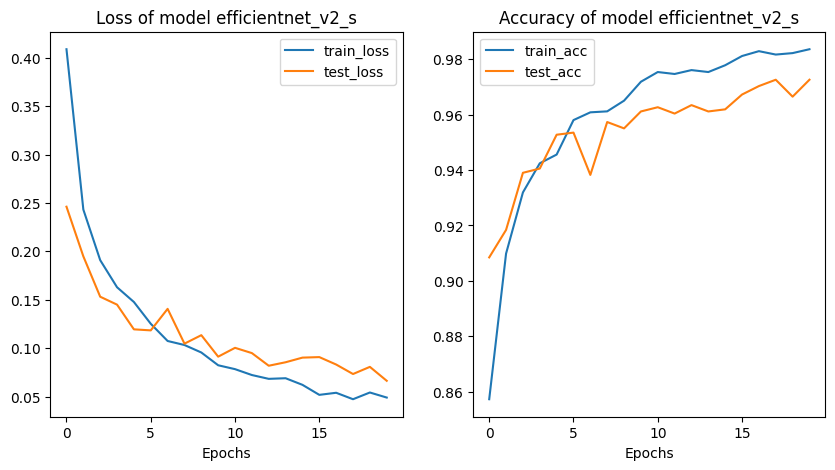

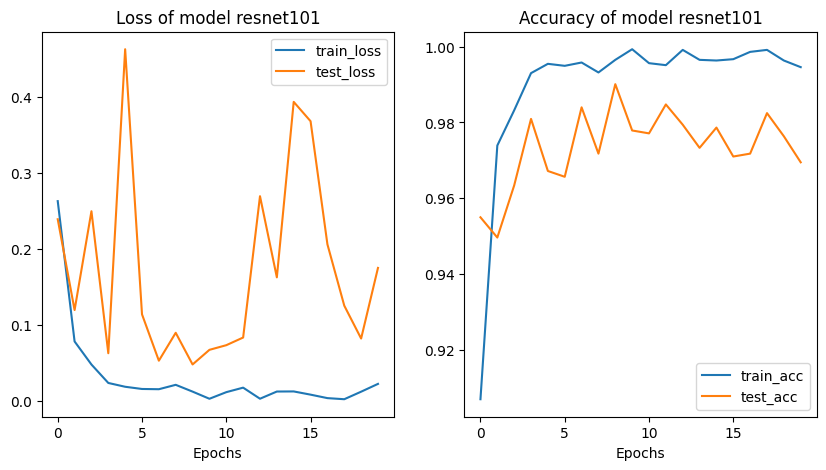

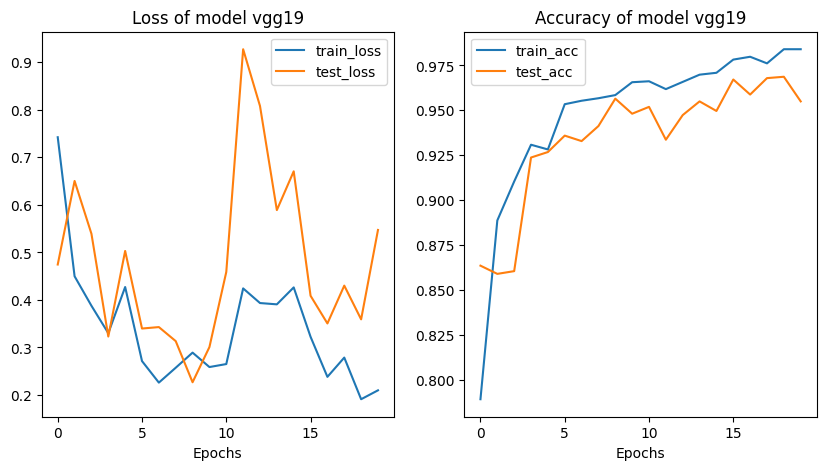

In [35]:
plot_curves(results,'efficientnet_v2_s')
plot_curves(results,'resnet101')
plot_curves(results,'vgg19')

# Predikcija modela i matrica pouzdanosti

Prvo ćemo pogledati predikciju modela na slučajno odabranom skupu slika a onda ćemo provesti predikciju na cijelom testnom skupu da bismo dobili matricu povjerenja.

In [73]:
def predict_and_plot_images(model : torch.nn.Module,
                            images_list : List[str],
                            classes: List[str],
                            nrow : int,
                            ncol:int,
                            figsize: Tuple[int,int],
                            device: torch.device=device):
  if len(images_list) % nrow != 0 or len(images_list) % ncol != 0:
    raise ValueError('Nije moguće nacrtati sve slike jer dimenzije mreže (nrow i ncol) nisu usklađene s brojem slika.')
  fig,axs = plt.subplots(nrow, ncol,figsize = figsize)

  model.to(device)
  model.eval()
  try:
    with torch.inference_mode():
      for idx, image_path in enumerate(images_list):
        with Image.open(image_path).convert('RGB') as img:
            transformed_img = model.weights.transforms()(img).unsqueeze(0).to(device)
            img_pred = model(transformed_img)
            img_prob = torch.softmax(img_pred,dim=1)
            img_pred_class = torch.argmax(img_prob, dim= 1).cpu().item()
            confidence = img_prob[0][img_pred_class].item()
            axs[idx//ncol, idx%ncol].imshow(img)
            axs[idx//ncol, idx%ncol].axis('off')
            img_class = image_path.split('/')[-2]
            axs[idx//ncol, idx%ncol].set_title(f'Predviđena klasa: {classes[img_pred_class]} | Stvarna klasa: {img_class} | Vj.: {confidence:.2f}', fontsize = 6)
    fig.suptitle(f'Predikcija {len(images_list)} slika modela {model.name}')
  except AttributeError:
    print('Pri definiciji modela potrebno je dodati atribute name i weights')
  plt.show()



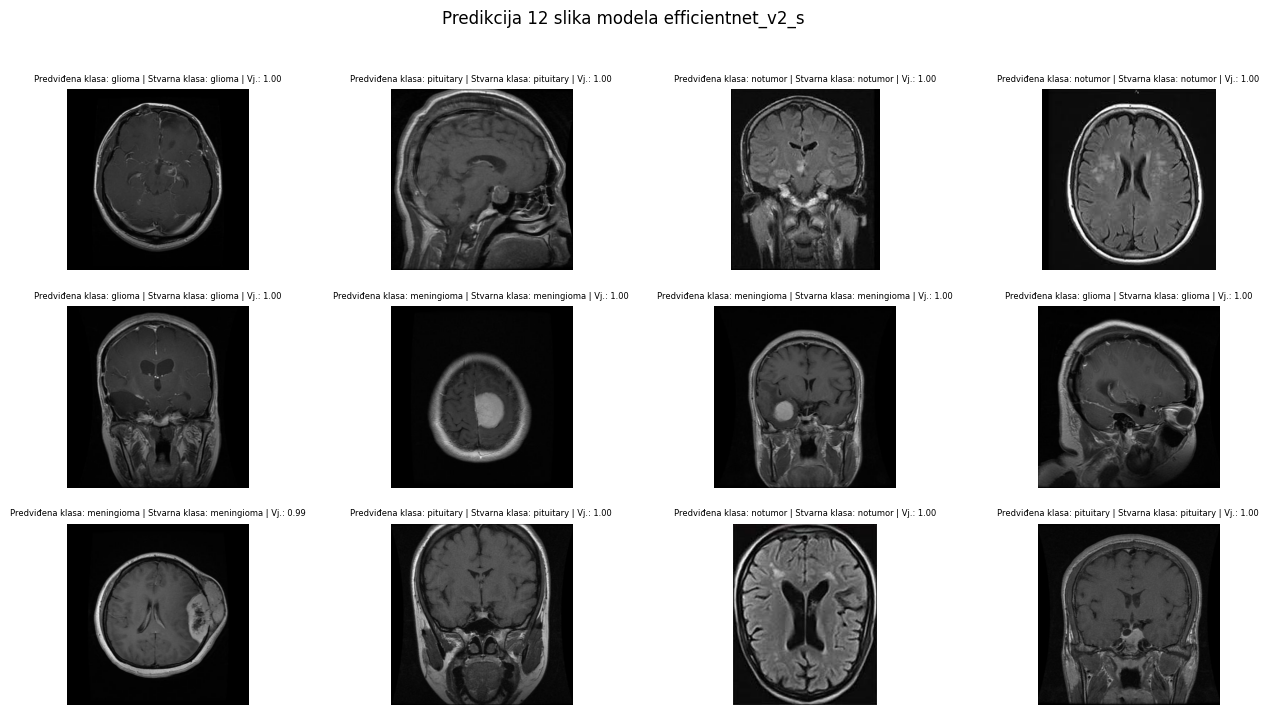

In [74]:
predict_and_plot_images(model_1, images_list=random.sample(total_images,12), classes=train_dataloader_1.dataset.classes, nrow=3, ncol=4, figsize=(16,8))

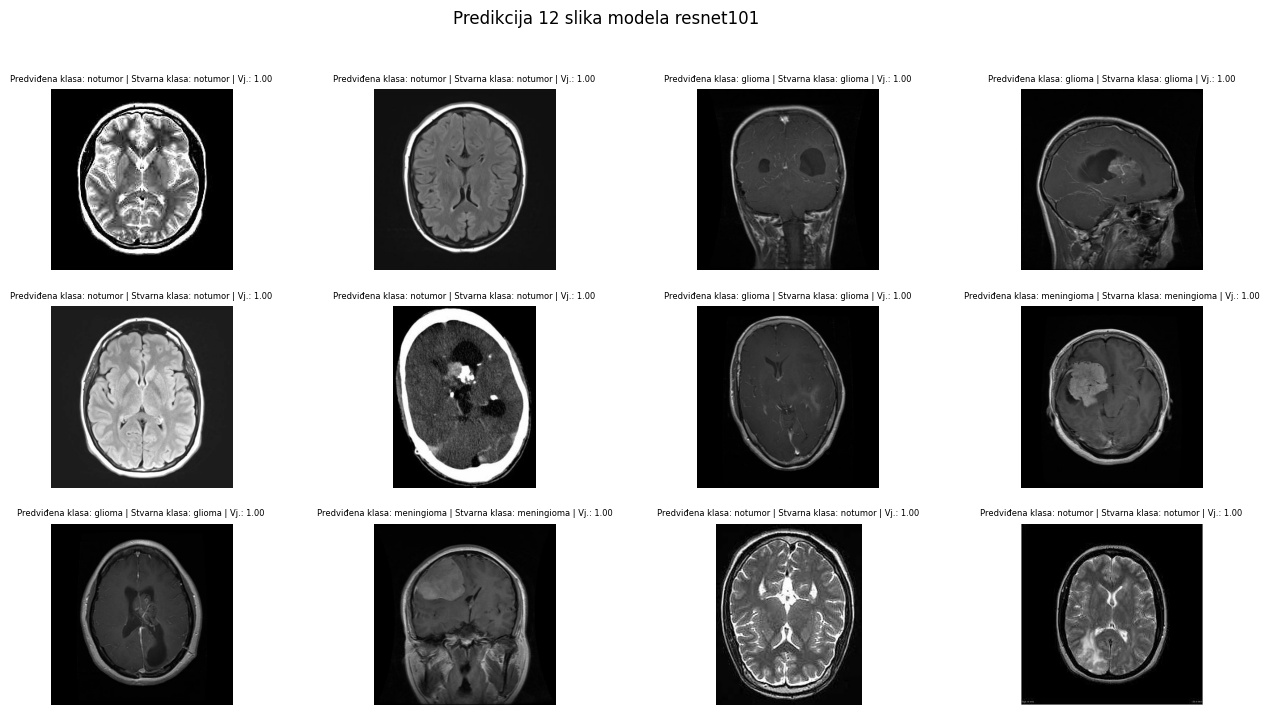

In [75]:
predict_and_plot_images(model_2, images_list=random.sample(total_images,12), classes=train_dataloader_2.dataset.classes, nrow=3, ncol=4, figsize=(16,8))

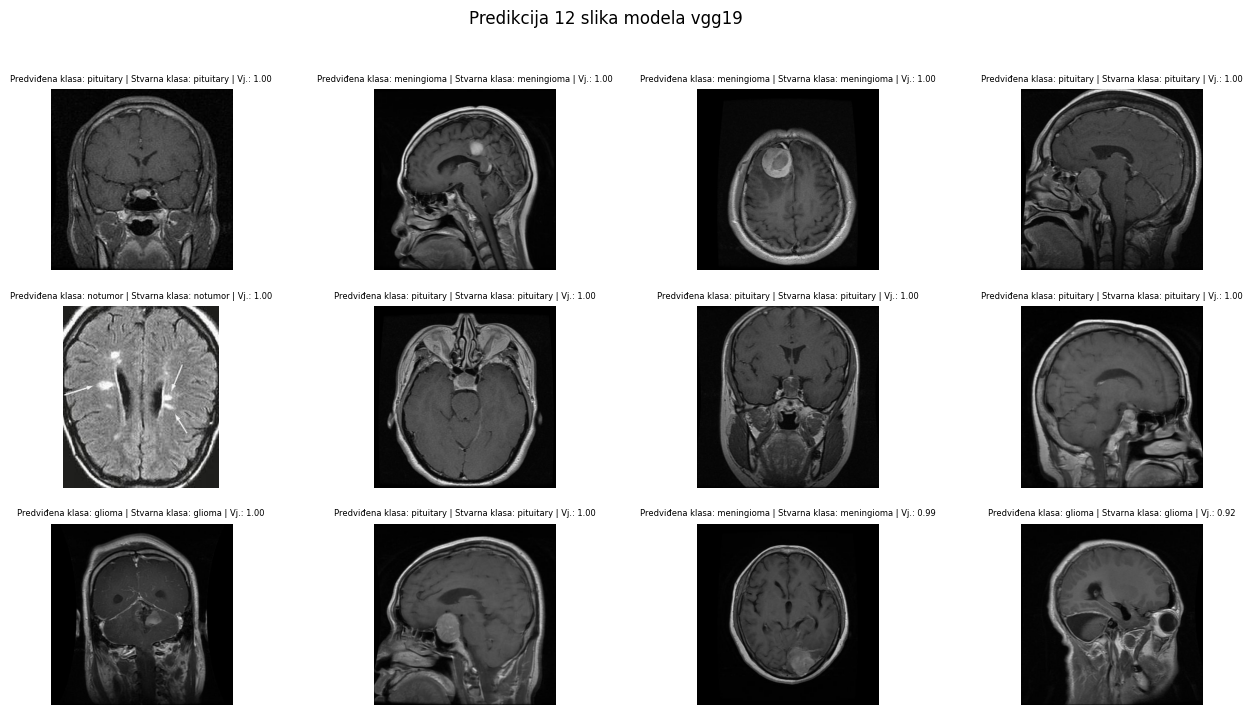

In [76]:
predict_and_plot_images(model_3, images_list=random.sample(total_images,12), classes=train_dataloader_3.dataset.classes, nrow=3, ncol=4, figsize=(16,8))

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from typing import List

def plot_confusion_matrix(model: torch.nn.Module,
                          test_dataloader: torch.utils.data.DataLoader,
                          device: torch.device = torch.device("cpu")) -> None:
    y_pred = []
    y_true = []
    classes = test_dataloader.dataset.classes

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(targets.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    model_name = getattr(model, "name", "model")
    plt.title(f'Confusion matrix for {model_name}')
    plt.show()


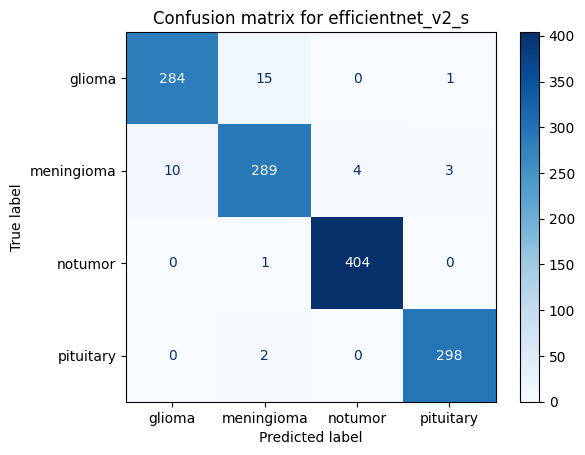

In [45]:
plot_confusion_matrix(model_1, test_dataloader_1, device)


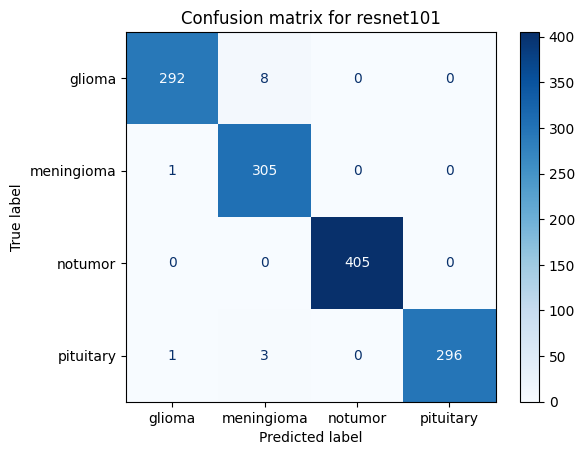

In [46]:
plot_confusion_matrix(model_2, test_dataloader_2, device)

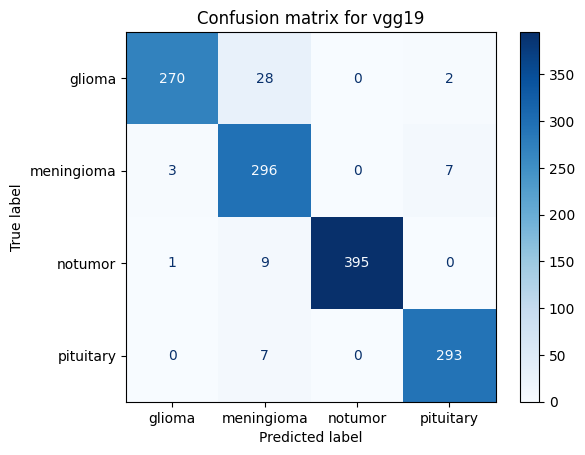

In [47]:
plot_confusion_matrix(model_3, test_dataloader_3, device)

I na kraju ćemo još usporediti modele.

In [83]:
import pandas as pd

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    learnable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, learnable

df = pd.DataFrame([
    {
        **results['efficientnet_v2_s']['best'],
        'duration': sum(results['efficientnet_v2_s']['duration'][:results['efficientnet_v2_s']['best']['epoch'] + 1]),
        'parameters': count_params(model_1)[0],
        'learnable_parameters': count_params(model_1)[1]
    },
    {
        **results['resnet101']['best'],
        'duration': sum(results['resnet101']['duration'][:results['resnet101']['best']['epoch'] + 1]),
        'parameters': count_params(model_2)[0],
        'learnable_parameters': count_params(model_2)[1]
    },
    {
        **results['vgg19']['best'],
        'duration': sum(results['vgg19']['duration'][:results['vgg19']['best']['epoch'] + 1]),
        'parameters': count_params(model_3)[0],
        'learnable_parameters': count_params(model_3)[1]
    }
])

print(df)

                                     model_path  epoch  test_loss  test_acc  \
0  /kaggle/working/models/efficientnet_v2_s.pth     19   0.066230  0.972540   
1          /kaggle/working/models/resnet101.pth      8   0.047869  0.990084   
2              /kaggle/working/models/vgg19.pth      8   0.226790  0.956522   

      duration  parameters  learnable_parameters  
0  1345.643076    20182612                335364  
1   425.462510    42508356              14972932  
2   513.615756   139586628             119562244  


Iz ovih rezultata vidimo da nam najbolju točnost i najmanji gubitak na testnom skupu daje arhitektura resnet101 te taj se rezultat dobije brže od ostalih modela.
Isto tako zanimljivo je vidjeti kako od svih arhitektura, model s najvećim brojem parametara daje najgori rezultat